In [9]:
%config IPCompleter.greedy=True #si puo' cancellare, è per avere l'autocompletion su jupyter notebook ma non pare funzionare
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd

class ImagePairDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing subfolders, each representing a sample.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = {}

        # Iterate over each subfolder in root_dir
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            match = re.search(r'\d+', subfolder)  # Extract the first number in the subfolder name
            if os.path.isdir(subfolder_path) and match:
                sample_idx = int(match.group())  # Convert the extracted number to an integer
                png_files = sorted([f for f in os.listdir(subfolder_path) if f.endswith('.png')])
                init_file = next((f for f in png_files if "init" in f), None)
                impact_file = next((f for f in png_files if "impact" in f), None)
                gt_file = next((f for f in os.listdir(subfolder_path) if f.endswith('output_displacement_external.csv')), None)
                init_coord_file = next((f for f in os.listdir(subfolder_path) if f.endswith('initial_coordinates_plate.csv')), None)
                if init_file and impact_file and gt_file and init_coord_file:
                    img1_path = os.path.join(subfolder_path, init_file)
                    img2_path = os.path.join(subfolder_path, impact_file)
                    gt_path = os.path.join(subfolder_path, gt_file)  # Ground truth displacement file path
                    init_coord_path = os.path.join(subfolder_path, init_coord_file)  #  initial plate coord file path
                    self.samples[sample_idx] = (img1_path, img2_path, gt_path, init_coord_path)
        
        # Convert dictionary to sorted list based on keys
        self.samples = [self.samples[i] for i in sorted(self.samples.keys())]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img1_path, img2_path, gt_path, init_coord_path = self.samples[idx]
        
        # Load the images
        img1 = Image.open(img1_path).convert('L')  # Load as single-channel grayscale
        img2 = Image.open(img2_path).convert('L')  # Load as single-channel grayscale

        # Create an RGB image with img1 in R channel and img2 in B channel
        img1_array = np.array(img1)
        img2_array = np.array(img2)
        rgb_image = np.zeros((img1_array.shape[0], img1_array.shape[1], 3), dtype=np.uint8)
        rgb_image[:, :, 0] = img1_array  # Assign to R channel
        rgb_image[:, :, 2] = img2_array  # Assign to B channel

        final_image = Image.fromarray(rgb_image)

        # Load the ground truth data (displacement external)
        init_coord_data = pd.read_csv(init_coord_path, skiprows=1, usecols=[1, 2])
        init_coord_data = init_coord_data.to_numpy().flatten()
        init_coord_data = torch.tensor(init_coord_data).float()

        # Load the ground truth data (displacement external)
        gt_data = pd.read_csv(gt_path, skiprows=1, usecols=[1, 2])
        gt_data = gt_data.to_numpy().flatten()
        gt_data = torch.tensor(gt_data).float()
        if self.transform:
            final_image = self.transform(final_image)

        return final_image, gt_data, init_coord_data

def calculate_target_normalization(dataloader):
    """
    Calculate mean and standard deviation for each of the 100 target dimensions
    across the entire training dataset
    """
    # Initialize arrays to store sums and squared sums for each dimension
    n_samples = 0
    sum_targets = None
    sum_squared_targets = None
    
    # Loop through the dataloader to collect statistics
    for batch_idx, (inputs, targets, init_data) in enumerate(dataloader):
        if sum_targets is None:
            # Initialize on first batch - we expect targets to be of shape [batch_size, 100]
            sum_targets = torch.zeros(targets.shape[1], dtype=torch.float64)
            sum_squared_targets = torch.zeros(targets.shape[1], dtype=torch.float64)
        
        # Convert targets to float64 for higher precision in accumulation
        targets = targets.to(dtype=torch.float64)
        
        # Update counts
        batch_size = targets.shape[0]
        n_samples += batch_size
        
        # Update sums and squared sums for each dimension
        sum_targets += torch.sum(targets, dim=0)
        sum_squared_targets += torch.sum(targets ** 2, dim=0)
        
    # Calculate mean and std for each dimension
    mean = sum_targets / n_samples
    # Use the formula: std = sqrt(E[X²] - E[X]²)
    var = (sum_squared_targets / n_samples) - (mean ** 2)
    # Handle potential numerical issues
    var = torch.clamp(var, min=1e-8)
    std = torch.sqrt(var)
    
    return {'mean': mean.numpy(), 'std': std.numpy()}

# Function to apply the normalization
def normalize_targets(targets, normalization_stats):
    """
    Apply standardization to targets using precomputed statistics
    """
    mean = torch.tensor(normalization_stats['mean'], dtype=targets.dtype, device=targets.device)
    std = torch.tensor(normalization_stats['std'], dtype=targets.dtype, device=targets.device)
    
    return (targets - mean) / std

# Function to inverse the normalization
def denormalize_targets(normalized_targets, normalization_stats):
    """
    Convert normalized targets back to original scale
    """
    mean = torch.tensor(normalization_stats['mean'], dtype=normalized_targets.dtype,
                         device=normalized_targets.device)
    std = torch.tensor(normalization_stats['std'], dtype=normalized_targets.dtype,
                        device=normalized_targets.device)
    
    return normalized_targets * std + mean


In [13]:
from torch.utils.data import random_split
from torch import nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision.models import  ResNet18_Weights
import copy
# Define the ResNet-based Model
class DisplacementNet(nn.Module):
    def __init__(self):
        super(DisplacementNet, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 278)  # Replace FC layer
    
    def forward(self, x):
        return self.resnet(x)

class DisplacementConvNet(nn.Module):
    def __init__(self):
        super(DisplacementConvNet, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 278)  # Replace FC layer
        
        #self.conv1 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=7, padding=3)
        #self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3, padding=1)
        #self.relu2 = nn.ReLU()
    
    def forward(self, x):
        x = self.resnet(x)  # ResNet forward pass
        x = x.view(-1, 2, 139)  # Reshape to (batch_size, 2, 139)
        #x = self.relu1(self.conv1(x))  # Apply first Conv1D layer
        x = self.conv2(x)  # Apply second Conv1D layer
        x = x.view(-1, 278)  # Reshape back to (batch_size, 278)
        return x

# Training Setup with Best Model Saving
def train_model(model, epochs=3, learning_rate=0.0001, train_loader=None, test_loader=None, norm_values=None):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize variables for tracking best model
    best_model_weights = None
    best_test_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, targets, init_data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            images = images.to(device)
            targets = normalize_targets(targets,norm_values).to(device)              
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                denorm_outputs = denormalize_targets(outputs, norm_values)
                denorm_targets = denormalize_targets(targets,norm_values)
                denorm_loss = criterion(denorm_outputs, denorm_targets)
                running_loss += denorm_loss.item() * images.size(0)
        
        train_loss = running_loss/len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}")
        
        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, targets, init_data in tqdm(test_loader, desc=f"Validating Epoch {epoch+1}", leave=False):
                images = images.to(device)
                targets = targets.to(device) 
                outputs = model(images)
                loss = criterion(denormalize_targets(outputs,norm_values), targets)
                test_loss += loss.item()*images.size(0)
        
        mean_test_loss = test_loss/len(test_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {mean_test_loss:.4f}")
        
        # Save the model weights if this epoch has the lowest test loss so far
        if mean_test_loss < best_test_loss:
            best_test_loss = mean_test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"New best model saved with test loss: {best_test_loss:.4f}")
    
    # Load the best model weights at the end of training
    if best_model_weights:
        model.load_state_dict(best_model_weights)
        print(f"Loaded best model weights with test loss: {best_test_loss:.4f}")
    else:
        print("Warning: No best model weights found.")
    
    print("Training Complete")
    return model


# Example usage:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DisplacementNet().to(device)

dataset = ImagePairDataset("/mnt/c/Users/engha/Downloads/deformazione-2d-parametrica/deformazione-2d-parametrica", transform=transform)
test_split = 0.2    
batch_size = 16
    # Split dataset into train and test sets
test_size = int(test_split * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
norm_values=calculate_target_normalization(train_loader)
trained_model = train_model(model=model, epochs=30,learning_rate=0.0001,train_loader=train_loader,test_loader=test_loader,norm_values=norm_values)

Epoch [1/30], Train Loss: 0.4962


Epoch [1/30], Test Loss: 0.2366
New best model saved with test loss: 0.2366


Epoch [2/30], Train Loss: 0.1669


Epoch [2/30], Test Loss: 0.0744
New best model saved with test loss: 0.0744


Epoch [3/30], Train Loss: 0.1589


Epoch [3/30], Test Loss: 0.0372
New best model saved with test loss: 0.0372


Epoch [4/30], Train Loss: 0.1052


Epoch [4/30], Test Loss: 0.0661


Epoch [5/30], Train Loss: 0.0754


Epoch [5/30], Test Loss: 0.0223
New best model saved with test loss: 0.0223


Epoch [6/30], Train Loss: 0.0811


Epoch [6/30], Test Loss: 0.0612


Epoch [7/30], Train Loss: 0.0738


Epoch [7/30], Test Loss: 0.0278


Epoch [8/30], Train Loss: 0.0673


Epoch [8/30], Test Loss: 0.0271


Epoch [9/30], Train Loss: 0.0474


Epoch [9/30], Test Loss: 0.0472


Epoch [10/30], Train Loss: 0.0425


Epoch [10/30], Test Loss: 0.1872


Epoch [11/30], Train Loss: 0.0438


Epoch [11/30], Test Loss: 0.0765


Epoch [12/30], Train Loss: 0.0368


Epoch [12/30], Test Loss: 0.0777


Epoch [13/30], Train Loss: 0.0280


Epoch [13/30], Test Loss: 0.1743


Epoch [14/30], Train Loss: 0.0224


Epoch [14/30], Test Loss: 0.0527


Epoch [15/30], Train Loss: 0.0200


Epoch [15/30], Test Loss: 0.0117
New best model saved with test loss: 0.0117


Epoch [16/30], Train Loss: 0.0181


Epoch [16/30], Test Loss: 0.0110
New best model saved with test loss: 0.0110


Epoch [17/30], Train Loss: 0.0180


Epoch [17/30], Test Loss: 0.0134


Epoch [18/30], Train Loss: 0.0167


Epoch [18/30], Test Loss: 0.0111


Epoch [19/30], Train Loss: 0.0127


Epoch [19/30], Test Loss: 0.0353


Epoch [20/30], Train Loss: 0.0186


Epoch [20/30], Test Loss: 0.0616


Epoch [21/30], Train Loss: 0.0183


Epoch [21/30], Test Loss: 0.0559


Epoch [22/30], Train Loss: 0.0139


Epoch [22/30], Test Loss: 0.0100
New best model saved with test loss: 0.0100


Epoch [23/30], Train Loss: 0.0133


Epoch [23/30], Test Loss: 0.0080
New best model saved with test loss: 0.0080


Epoch [24/30], Train Loss: 0.0119


Epoch [24/30], Test Loss: 0.0127


Epoch [25/30], Train Loss: 0.0118


Epoch [25/30], Test Loss: 0.0377


Epoch [26/30], Train Loss: 0.0255


Epoch [26/30], Test Loss: 0.0338


Epoch [27/30], Train Loss: 0.0131


Epoch [27/30], Test Loss: 0.0129


Epoch [28/30], Train Loss: 0.0119


Epoch [28/30], Test Loss: 0.0076
New best model saved with test loss: 0.0076


Epoch [29/30], Train Loss: 0.0081


Epoch [29/30], Test Loss: 0.0087


Epoch [30/30], Train Loss: 0.0073


Epoch [30/30], Test Loss: 0.0065
New best model saved with test loss: 0.0065
Loaded best model weights with test loss: 0.0065
Training Complete


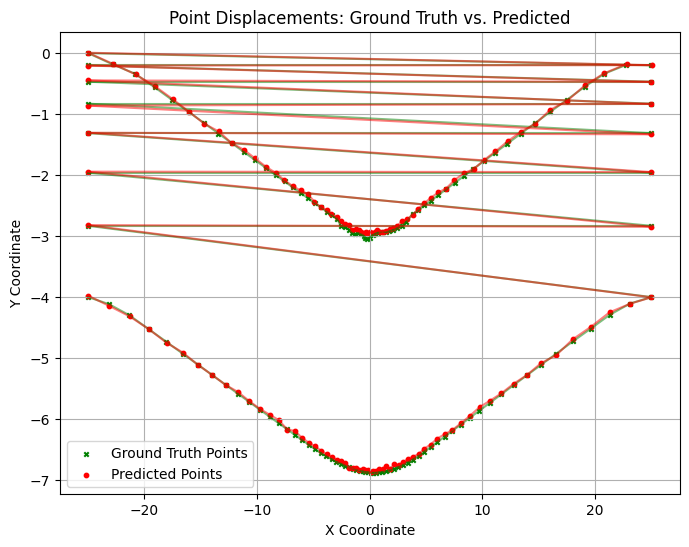

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def plot_points_sequence(init_coord_data, gt_data, predicted_displacements):
    """
    Plots the positions of points given the initial coordinates, ground truth displacements,
    and predicted displacements. Also, plots lines connecting successive points for both sequences.

    Args:
        init_coord_data (numpy.ndarray): Initial positions of the points of shape (N, 2).
        gt_data (numpy.ndarray): Ground truth displacement data of shape (N, 2).
        predicted_displacements (numpy.ndarray): Predicted displacement data of shape (N, 2).
    """
    # Calculate the final ground truth points
    gt_points = init_coord_data + gt_data
    
    # Calculate the predicted points
    predicted_points = init_coord_data + predicted_displacements
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Plot ground truth points (smaller 'x' markers)
    plt.scatter(gt_points[:, 0], gt_points[:, 1], color='green', label='Ground Truth Points', marker='x', s=10)
    
    # Plot predicted points (smaller 'o' markers)
    plt.scatter(predicted_points[:, 0], predicted_points[:, 1], color='red', label='Predicted Points', marker='o', s=10)
    
    # Connect the ground truth points to their successors
    for i in range(len(gt_points) - 1):
        plt.plot([gt_points[i, 0], gt_points[i + 1, 0]], [gt_points[i, 1], gt_points[i + 1, 1]], 'g-', alpha=0.5)
    
    # Connect the predicted points to their successors
    for i in range(len(predicted_points) - 1):
        plt.plot([predicted_points[i, 0], predicted_points[i + 1, 0]], [predicted_points[i, 1], predicted_points[i + 1, 1]], 'r-', alpha=0.5)
    
    # Labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Point Displacements: Ground Truth vs. Predicted')
    
    # Add legend
    plt.legend()
    
    # Show plot
    plt.grid(True)
    plt.show()

# Example usage for a given sample index
# Assuming `init_coord_data`, `gt_data`, and `predicted_displacements` are NumPy arrays of shape (N, 2)
init_coord_data = np.random.rand(140, 2)  # Initial coordinates of 140 poin


# Example usage for a given sample index
# Assuming `init_coord_data`, `gt_data`, and `predicted_displacements` are NumPy arrays of shape (N, 2)
# For example:
images, targets, init_data = test_loader.dataset[70]
images = images.to(device)
images = images[None,:, :, :]
init_data = init_data.numpy().reshape(-1,2)
targets = targets.numpy().reshape(-1,2)
predicted_displacements = trained_model(images)
predicted_displacements = predicted_displacements.cpu().detach().numpy()
predicted_displacements = predicted_displacements.reshape(-1,2)
#import pdb; pdb.set_trace()
# Call the function to plot the points for a sample
plot_points_sequence(init_data, targets, predicted_displacements)



In [1]:
def plot_image_tensor(image_tensor):
    """
    Takes a PyTorch tensor representing image data and plots the image.

    Args:
        image_tensor (torch.Tensor): A tensor representing image data with shape 
                                     (batch_size, channels, height, width).
    """
    # Check if the tensor is a single image or a batch
    if image_tensor.ndimension() == 4:
        # If batch size is greater than 1, let's plot the first image
        image_tensor = image_tensor[0]  # Take the first image in the batch
    
    # Convert the tensor to a NumPy array and move channels to last dimension (for plotting)
    image_array = image_tensor.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    #image_array[:, :, 1] = 1
    # If the image is grayscale (single channel), it will have only one channel
    if image_array.shape[2] == 1:
        image_array = image_array[:, :, 0]  # Convert to 2D for grayscale images
    
    # Plot the image
    plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
    plt.axis('off')  # Hide axes
    plt.show()

plot_image_tensor(images[:,:,:,:].cpu())

NameError: name 'images' is not defined

In [ ]:
images.shape